<a href="https://colab.research.google.com/github/amenem/test/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Prepare Colab**

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
import os
os.chdir('/content/drive/My Drive/GoodProject')

In [ ]:
from google.colab import files
import warnings  
warnings.filterwarnings('ignore')    

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amenem","key":"f0913597f85de0138806c77add36fa0f"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c fake-news

  0% 0.00/40.6k [00:00<?, ?B/s]
100% 40.6k/40.6k [00:00<00:00, 5.63MB/s]
 53% 5.00M/9.42M [00:00<00:00, 37.8MB/s]
100% 9.42M/9.42M [00:00<00:00, 46.0MB/s]
 97% 36.0M/37.0M [00:01<00:00, 21.0MB/s]
100% 37.0M/37.0M [00:01<00:00, 19.7MB/s]


In [ ]:
! unzip ./train.csv.zip -d ./
! unzip ./test.csv.zip -d ./

Archive:  ./train.csv.zip
  inflating: ./train.csv             
Archive:  ./test.csv.zip
  inflating: ./test.csv              


Import Relevant Libraries

In [5]:
import pandas as pd
import numpy as np
import keras
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.callbacks import Callback, ModelCheckpoint
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [6]:
df_train = pd.read_csv('./train.csv')
df_train = df_train.dropna(subset=['text'])
df_train = df_train.fillna(' ')


I am not considering Author information, assuming title and text should provide enough information for the model.
Its also not very helpful to treat authors as regular text, So pretrained word embedding woldnt work.
If it is required, we can randomly initialize and fine tune author embedding vector while training the model. 
For now keeping it simple.

In [7]:
df_train['title+text']=df_train['title']+' '+df_train['text']
X=df_train['title+text'].values
X=[text.lower() for text in X]
y = df_train['label']


In [8]:
max_num_words = 20000
tokenizer = Tokenizer(max_num_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

In [9]:
len_sent_list=[]
for text in X:
  len_sent = len(text.split())
  len_sent_list.append(len_sent)

Average Text length: 772.3865902413179


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 0, 'Text length distribution')

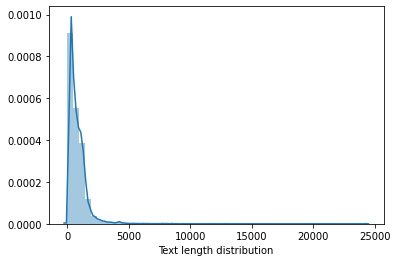

In [10]:
import seaborn as sb
import matplotlib.pyplot as plt

print ("Average Text length: "+str(np.average(len_sent_list)))
sb.distplot(len_sent_list)
plt.xlabel('Text length distribution')

The more the words in the text the better the understanding of the context. Setting Maximum text length to 1000 word, which can be well handled by CNN. In Constrast, RNN might suffer with vanishing gradient for long sequences.Even for LSTM reasonable limit would be 250-500 time steps. 

In [16]:
#get padded sequence of input
MAXLEN=1000
sequences = tokenizer.texts_to_sequences(X)
padded = pad_sequences(sequences, maxlen=MAXLEN, padding='post',truncating='post')

In [30]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip

Using Glove pretrained word embedding. It combines benefits of word2vec skip-gram model  in the word analogy tasks, with matrix factorization methods exploiting global statistical information. 

In [11]:
#load glove pretrained word embeddings with dimension 100
glove_file = 'glove.6B.100d.txt'

print('Indexing word vectors...')
embeddings_index = {}
f = open(glove_file, encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors...
Found 400000 word vectors.


Keeping 30% of data as test.

In [17]:
X_train, X_val, y_train, y_val = train_test_split(padded,y,test_size=.3, random_state=23)

In [18]:
#build embedding matrix
EMBED_DIM=100
embedding_matrix=np.zeros((len(word_index)+1, EMBED_DIM))
for word,idx in word_index.items():
  embedding_vector=embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[idx]=embedding_vector

In [63]:
embedding_layer = Embedding(len(word_index)+1, EMBED_DIM, input_length=MAXLEN, 
                            weights=[embedding_matrix],
                            trainable=False)
model=Sequential()
model.add(embedding_layer) 
model.add(Conv1D(32,3,activation='relu'))
model.add(MaxPool1D(3))
model.add(Conv1D(32,3,activation='relu'))
model.add(MaxPool1D(3))
model.add(Conv1D(32,3,activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [64]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 100)          24150100  
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 498, 32)           9632      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 166, 32)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 164, 32)           3104      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 54, 32)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 52, 32)            3104      
_________________________________________________________________
flatten_5 (Flatten)          (None, 1664)             

In [65]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [66]:
checkpoint = ModelCheckpoint('best_model.h5', verbose=0, monitor='val_loss',save_best_only=True, mode='auto') 

history=model.fit(X_train,y_train,epochs=40,validation_data=(X_val,y_val),batch_size=128,callbacks=[checkpoint])

Epoch 1/40
114/114 [==============================] - 7s 58ms/step - loss: 0.5129 - accuracy: 0.7291 - val_loss: 0.3135 - val_accuracy: 0.8672
Epoch 2/40
114/114 [==============================] - 3s 29ms/step - loss: 0.1713 - accuracy: 0.9321 - val_loss: 0.1162 - val_accuracy: 0.9546
Epoch 3/40
114/114 [==============================] - 3s 29ms/step - loss: 0.0848 - accuracy: 0.9688 - val_loss: 0.0861 - val_accuracy: 0.9671
Epoch 4/40
114/114 [==============================] - 3s 29ms/step - loss: 0.0537 - accuracy: 0.9790 - val_loss: 0.0785 - val_accuracy: 0.9703
Epoch 5/40
114/114 [==============================] - 3s 25ms/step - loss: 0.0353 - accuracy: 0.9880 - val_loss: 0.0823 - val_accuracy: 0.9672
Epoch 6/40
114/114 [==============================] - 3s 25ms/step - loss: 0.0202 - accuracy: 0.9935 - val_loss: 0.1297 - val_accuracy: 0.9539
Epoch 7/40
114/114 [==============================] - 3s 25ms/step - loss: 0.0198 - accuracy: 0.9937 - val_loss: 0.0876 - val_accuracy: 0.9716

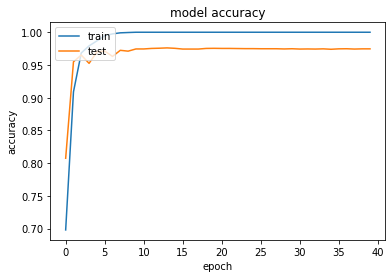

In [61]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

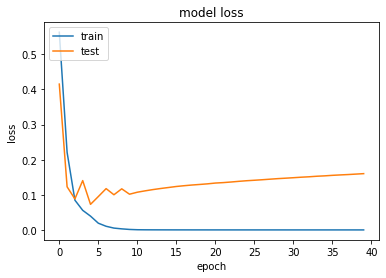

In [62]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

This model reaches 97.3% classification accuracy on the validation set. Its already a good result. But we still want to see if it can be further improved using hyperparameters tuning.

**Hyperparameters optimization**

In [13]:
def build_model(num_filters, kernel_size, pool_size, fc1_size, max_len,emb_dim):
  MAXLEN=max_len
  EMBED_DIM=emb_dim
  embedding_layer = Embedding(len(word_index)+1, EMBED_DIM, input_length=MAXLEN, 
                              weights=[embedding_matrix],
                              trainable=False)
  model=Sequential()
  model.add(embedding_layer)
  model.add(Conv1D(num_filters,kernel_size,activation='relu'))
  model.add(MaxPool1D(pool_size))
  model.add(Conv1D(num_filters,kernel_size,activation='relu'))
  model.add(MaxPool1D(pool_size))
  model.add(Conv1D(num_filters,kernel_size,activation='relu'))
  model.add(Flatten())
  model.add(Dense(fc1_size, activation='relu'))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
  return model


In [22]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Parameter grid for grid search
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  pool_size=[3, 5, 7],
                  dense_layer_size=[32,64,128]
                  max_len=[1000],
                  emb_dim=[100])
model = KerasClassifier(build_fn=build_model,
                        epochs=10, batch_size=128,
                        verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(X_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(X_val, y_val)
print (grid_result.best_score_)
print (grid_result.best_params_)


Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 12.6min finished


0.9813515245914459
{'pool_size': 7, 'num_filters': 128, 'max_len': 1000, 'kernel_size': 3, 'emb_dim': 100}


In [23]:
# Build Model with tuned Hypermaters

In [26]:
num_filters=128
kernel_size=3
pool_size= 7
fc1_size=128

embedding_layer = Embedding(len(word_index)+1, EMBED_DIM, input_length=MAXLEN, 
                            weights=[embedding_matrix],
                            trainable=False)
model=Sequential()
model.add(embedding_layer)
model.add(Conv1D(num_filters,kernel_size,activation='relu'))
model.add(MaxPool1D(pool_size))
model.add(Conv1D(num_filters,kernel_size,activation='relu'))
model.add(MaxPool1D(pool_size))
model.add(Conv1D(num_filters,kernel_size,activation='relu'))
model.add(Flatten())
model.add(Dense(fc1_size, activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

checkpoint = ModelCheckpoint('best_model.h5', verbose=0, monitor='val_loss',save_best_only=True, mode='auto') 
history=model.fit(X_train,y_train,epochs=40,validation_data=(X_val,y_val),batch_size=128,callbacks=[checkpoint])

Epoch 1/40
114/114 [==============================] - 11s 96ms/step - loss: 0.4421 - accuracy: 0.7740 - val_loss: 0.1994 - val_accuracy: 0.9210
Epoch 2/40
114/114 [==============================] - 8s 67ms/step - loss: 0.1288 - accuracy: 0.9516 - val_loss: 0.0900 - val_accuracy: 0.9671
Epoch 3/40
114/114 [==============================] - 8s 66ms/step - loss: 0.0481 - accuracy: 0.9827 - val_loss: 0.0784 - val_accuracy: 0.9695
Epoch 4/40
114/114 [==============================] - 8s 66ms/step - loss: 0.0311 - accuracy: 0.9886 - val_loss: 0.0495 - val_accuracy: 0.9836
Epoch 5/40
114/114 [==============================] - 7s 62ms/step - loss: 0.0076 - accuracy: 0.9981 - val_loss: 0.0566 - val_accuracy: 0.9780
Epoch 6/40
114/114 [==============================] - 7s 63ms/step - loss: 0.0032 - accuracy: 0.9996 - val_loss: 0.0638 - val_accuracy: 0.9825
Epoch 7/40
114/114 [==============================] - 7s 62ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0979 - val_accuracy: 0.977

In [27]:
#validation accuracy has increased approximately by 1% from 97.43% to 98.36% !!

In [ ]:
## lets try further by fine tuning the glove word embedding and reglarizing with dropout layers.

In [36]:
num_filters=128
kernel_size=3
pool_size= 7
fc1_size=128

embedding_layer = Embedding(len(word_index)+1, EMBED_DIM, input_length=MAXLEN, 
                            weights=[embedding_matrix],
                            trainable=True)
model=Sequential()
model.add(embedding_layer)
model.add(Conv1D(num_filters,kernel_size,activation='relu'))
model.add(Dropout(.5))
model.add(MaxPool1D(pool_size))
model.add(Conv1D(num_filters,kernel_size,activation='relu'))
model.add(Dropout(.5))
model.add(MaxPool1D(pool_size))
model.add(Conv1D(num_filters,kernel_size,activation='relu'))
model.add(Dropout(.5))
model.add(Flatten())
model.add(Dense(fc1_size, activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

checkpoint = ModelCheckpoint('best_model.h5', verbose=0, monitor='val_loss',save_best_only=True, mode='auto') 
history=model.fit(X_train,y_train,epochs=40,validation_data=(X_val,y_val),callbacks=[checkpoint])

Epoch 1/40
455/455 [==============================] - 110s 242ms/step - loss: 0.3832 - accuracy: 0.8202 - val_loss: 0.1039 - val_accuracy: 0.9717
Epoch 2/40
455/455 [==============================] - 111s 244ms/step - loss: 0.0754 - accuracy: 0.9743 - val_loss: 0.0513 - val_accuracy: 0.9864
Epoch 3/40
455/455 [==============================] - 114s 251ms/step - loss: 0.0381 - accuracy: 0.9867 - val_loss: 0.0386 - val_accuracy: 0.9891
Epoch 4/40
455/455 [==============================] - 114s 250ms/step - loss: 0.0240 - accuracy: 0.9913 - val_loss: 0.0305 - val_accuracy: 0.9912
Epoch 5/40
455/455 [==============================] - 114s 250ms/step - loss: 0.0197 - accuracy: 0.9937 - val_loss: 0.0336 - val_accuracy: 0.9908
Epoch 6/40
455/455 [==============================] - 110s 242ms/step - loss: 0.0116 - accuracy: 0.9966 - val_loss: 0.0319 - val_accuracy: 0.9894
Epoch 7/40
455/455 [==============================] - 113s 247ms/step - loss: 0.0098 - accuracy: 0.9964 - val_loss: 0.0303 -

Bit improvement on the validation accuracy which has reached 99% now.

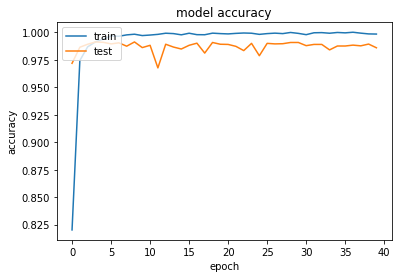

In [37]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

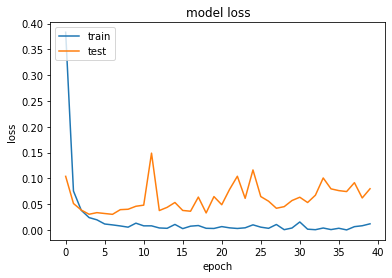

In [38]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**F1** **Score**

In [39]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_val)
y_pred_bool = y_pred>=0.7

print(classification_report(y_val, y_pred_bool))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3163
           1       0.98      0.99      0.99      3066

    accuracy                           0.99      6229
   macro avg       0.99      0.99      0.99      6229
weighted avg       0.99      0.99      0.99      6229



**Prediction on Test data**

In [32]:
df_test = pd.read_csv('./test.csv')

In [33]:
df_test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [40]:
df_test=df_test.fillna(' ')
X_test=df_test['title'] + ' '+ df_test['text']


In [42]:
def predict(text):
  sequences_test = tokenizer.texts_to_sequences(text)
  padded = pad_sequences(sequences_test, maxlen=MAXLEN, padding='post',truncating='post')
  label=model.predict(padded)
  return label 

output_labels=[]
c=0
for text in X_test:
  text=text.lower()
  c+=1
  if (c%1000==0):
    print (str(c)+' '+'predicted!')
  value=predict([text])
  if (value[0][0]>.5):
    output_labels.append(1)
  else: 
    output_labels.append(0)


1000 predicted!
2000 predicted!
3000 predicted!
4000 predicted!
5000 predicted!


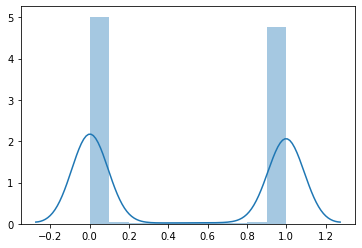

class output probability are clearly separable

In [47]:
df_submit = pd.read_csv('./submit.csv')

In [49]:
df_submit.columns

Index(['id', 'label'], dtype='object')

In [51]:
df_submit['label']=output_labels

In [53]:
df_submit.to_csv('./submit.csv')